### Николаев Евгений Алексеевич, Группа 22.М08-мм

## Задача 2. Сравнение методов классификации

#### Задачи:

- [x] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [x] Взять данные для предсказания заболеваний сердца тут (целевой признак для предсказания --- target). Демо блокнот с анализом этих данных можно найти тут.
- [x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).
- [x] Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (Feature Engineering).
- [x] Используя подбор гиперпараметров, кросс-валидацию и при необходимости масштабирование данных, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [x] Повторить предыдущий пункт для библиотечных реализаций (например, из sklearn) всех пройденных методов классификации (logistic regression, svm, knn, naive bayes, decision tree).
- [x] Сравнить все обученные модели, построить их confusion matrices. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [x] (+2 балла) Реализовать еще один из методов классификации и добавить его в сравнение.
- [x] (+2 балла) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

In [127]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import norm
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.datasets import load_wine
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import LabelEncoder

### Реализация метода k-nn

In [128]:
class KNNClass(BaseEstimator, ClassifierMixin):
    def __init__(self, num_neighbors=3):
        self._num_neighbors = num_neighbors

    def fit(self, X_train, y_train):
        X_train, y_train = check_X_y(X_train, y_train)
        self._X_train = X_train
        self._y_train = y_train
        return self

    def predict(self, X_test):
        X_test = check_array(X_test)
        predictions = []
        for test_row in X_test:
            neighbors_indexes = self._get_neighbors_indexes(test_row)
            label = self._most_popular_label(neighbors_indexes)
            predictions.append(label)
        return predictions

    def _get_neighbors_indexes(self, test_row):
        distances = list()
        for i, train_row in enumerate(self._X_train):
            dist = self._euclidean_distance(test_row, train_row)
            distances.append((i, dist))
        distances.sort(key=lambda tupl: tupl[1])
        neighbors_indexes = list()
        for i in range(self._num_neighbors):
            neighbors_indexes.append(distances[i][0])
        return neighbors_indexes

    def _most_popular_label(self, neighbors_indexes):
        labels = []
        for i in neighbors_indexes:
            labels.append(self._y_train[i])
        label = max(set(labels), key=labels.count)
        return label

    def _euclidean_distance(self, row1, row2):
        distance = 0.0
        for i in range(len(row1) - 1):
            distance += (row1[i] - row2[i]) ** 2
        return np.sqrt(distance)

    def get_params(self, deep=True):
        return {"num_neighbors": self._num_neighbors}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

### Реализация метода SVM

In [129]:
class SVMClass(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha_value=1E-1, lamda_value=1E-1):
        self._alpha_value = alpha_value
        self._lamda_value = lamda_value

    def fit(self, X_train, y_train):
        X_train, y_train = check_X_y(X_train, y_train)
        self._X_train = X_train
        self._y_train = y_train
        self._update_weights()
        return self

    def _update_weights(self):
        y_train_labels = np.where(self._y_train <= 0, -1, 1)
        self.w = np.zeros(self._X_train.shape[1])
        self.b = 0
        for i, train_row in enumerate(self._X_train):
            dw = 0
            db = 0
            if y_train_labels[i] * (np.dot(train_row, self.w) - self.b) >= 1:
                dw = 2 * self._lamda_value * self.w
                db = 0
            else:
                dw = 2 * self._lamda_value * self.w - np.dot(train_row, y_train_labels[i])
                db = y_train_labels[i]
            self.w = self.w - self._alpha_value * dw
            self.b = self.b - self._alpha_value * db

    def predict(self, X_test):
        X_test = check_array(X_test)
        labels = np.sign(np.dot(X_test, self.w) - self.b)
        predictions = np.where(labels <= -1, 0, 1)
        return predictions

    def get_params(self, deep=True):
        return {"alpha_value": self._alpha_value,
                "lamda_value": self._lamda_value}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   trestbps  1025 non-null   int64  
 3   chol      1025 non-null   int64  
 4   fbs       1025 non-null   int64  
 5   restecg   1025 non-null   int64  
 6   thalach   1025 non-null   int64  
 7   exang     1025 non-null   int64  
 8   oldpeak   1025 non-null   float64
 9   ca        1025 non-null   int64  
 10  target    1025 non-null   int64  
 11  cp_0      1025 non-null   uint8  
 12  cp_1      1025 non-null   uint8  
 13  cp_2      1025 non-null   uint8  
 14  cp_3      1025 non-null   uint8  
 15  thal_0    1025 non-null   uint8  
 16  thal_1    1025 non-null   uint8  
 17  thal_2    1025 non-null   uint8  
 18  thal_3    1025 non-null   uint8  
 19  slope_0   1025 non-null   uint8  
 20  slope_1   1025 non-null   uint

In [131]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


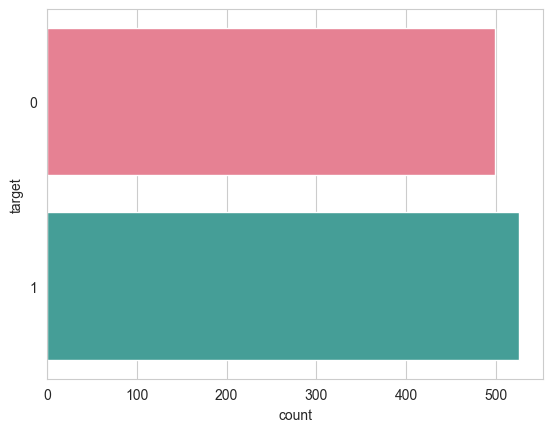

1    526
0    499
Name: target, dtype: int64

In [132]:
sns.countplot(data=df, y="target", palette="husl")
plt.show()
df.target.value_counts()

Количество пациентов с заболеванием сердца и без (1 - с заболеванием, 0 - без)

In [133]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp")
thal_dum = pd.get_dummies(df['thal'], prefix = "thal")
slope_dum = pd.get_dummies(df['slope'], prefix = "slope")

frames = [df, cp_dum, thal_dum, slope_dum]
df = pd.concat(frames, axis = 1)
df = df.drop(columns = ['cp', 'thal', 'slope'])
df.columns

Index(['age', 'sex', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
       'oldpeak', 'ca', 'target', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'thal_0',
       'thal_1', 'thal_2', 'thal_3', 'slope_0', 'slope_1', 'slope_2'],
      dtype='object')

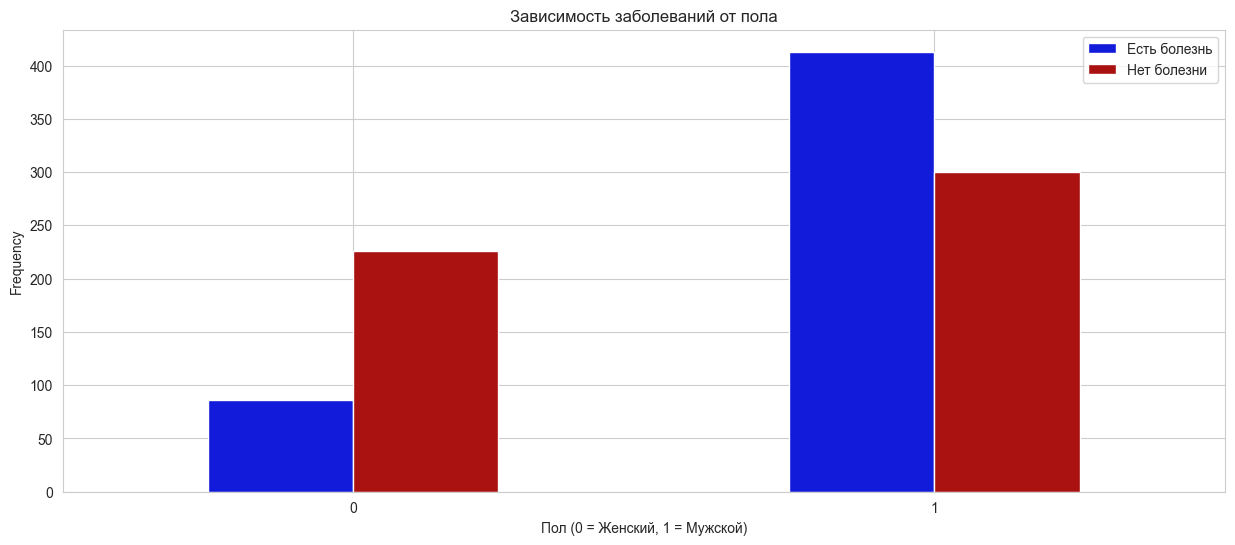

In [134]:
pd.crosstab(df.sex,df.target).plot(kind="bar",figsize=(15,6),color=['#111bd9','#AA1111' ])
plt.title('Зависимость заболеваний от пола')
plt.xlabel('Пол (0 = Женский, 1 = Мужской)')
plt.xticks(rotation=0)
plt.legend(["Есть болезнь", "Нет болезни"])
plt.ylabel('Frequency')
plt.show()

Кол-во пациентов - заболевание сердца от типа боли

### Разбиение на тренировочную и тестовую выборки


In [135]:
x = df.drop(['target'], axis=1)
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

### Масштабирование

In [136]:
scaler = StandardScaler()

x_train_scaled_raw = scaler.fit_transform(x_train)
x_test_scaled_raw = scaler.transform(x_test)
x_train_scaled = pd.DataFrame(x_train_scaled_raw, columns=x.columns)
x_test_scaled = pd.DataFrame(x_test_scaled_raw, columns=x.columns)
x_train_scaled.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,0.211946,-1.568266,3.800822,0.867097,2.533829,-0.995693,-0.719804,1.369819,2.384045,1.147721,...,-0.455573,-0.625543,-0.279096,-0.044237,-0.249481,-1.072968,1.213849,3.345217,-0.946729,-0.896001
1,-1.195951,0.637647,0.037294,0.041043,2.533829,-0.995693,-0.284435,1.369819,-0.836399,3.040260,...,-0.455573,-0.625543,-0.279096,-0.044237,-0.249481,-1.072968,1.213849,-0.298934,1.056268,-0.896001
2,-0.437853,0.637647,0.701446,-0.905897,-0.394660,-0.995693,-1.024562,1.369819,-0.175795,-0.744818,...,-0.455573,-0.625543,-0.279096,-0.044237,-0.249481,-1.072968,1.213849,-0.298934,1.056268,-0.896001
3,-0.979352,0.637647,-0.184090,1.270050,-0.394660,-0.995693,0.891060,-0.730023,-0.918975,-0.744818,...,2.195036,-0.625543,-0.279096,-0.044237,-0.249481,0.931994,-0.823826,-0.298934,-0.946729,1.116071
4,-2.062350,0.637647,-0.516166,-1.067079,-0.394660,0.892436,1.065207,-0.730023,-0.918975,-0.744818,...,2.195036,-0.625543,-0.279096,-0.044237,-0.249481,0.931994,-0.823826,-0.298934,-0.946729,1.116071


### Кросс-валидация с подборкой гиперпараметров


In [137]:
rfecv = RFECV(estimator=RidgeClassifierCV())
rfecv.fit(x_train_scaled, y_train)
selected_features = list(x_train_scaled.columns[rfecv.support_])
print("Optimal features: ", rfecv.n_features_)
print("Selected features: ", selected_features)

Optimal features:  12
Selected features:  ['sex', 'trestbps', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_0', 'cp_2', 'thal_2', 'thal_3', 'slope_1', 'slope_2']


In [138]:
scores = {}

### Собственная реализация KNN

In [139]:
cv = StratifiedKFold(5, shuffle=True, random_state=18)
param_grid = [{"num_neighbors": [3, 4, 6, 8, 11, 12, 16]}]
searcher = GridSearchCV(KNNClass(), param_grid=param_grid, cv=cv, verbose=5)
searcher = searcher.fit(x_train_scaled, y_train)
optimal_num_neighbors = searcher.best_params_["num_neighbors"]
print("Optimal num_neighbors =", optimal_num_neighbors)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ...................num_neighbors=3;, score=0.835 total time=   0.2s
[CV 2/5] END ...................num_neighbors=3;, score=0.883 total time=   0.2s
[CV 3/5] END ...................num_neighbors=3;, score=0.873 total time=   0.2s
[CV 4/5] END ...................num_neighbors=3;, score=0.853 total time=   0.2s
[CV 5/5] END ...................num_neighbors=3;, score=0.902 total time=   0.2s
[CV 1/5] END ...................num_neighbors=4;, score=0.835 total time=   0.2s
[CV 2/5] END ...................num_neighbors=4;, score=0.883 total time=   0.2s
[CV 3/5] END ...................num_neighbors=4;, score=0.873 total time=   0.2s
[CV 4/5] END ...................num_neighbors=4;, score=0.853 total time=   0.2s
[CV 5/5] END ...................num_neighbors=4;, score=0.902 total time=   0.2s
[CV 1/5] END ...................num_neighbors=6;, score=0.835 total time=   0.2s
[CV 2/5] END ...................num_neighbors=6;,

### Собственная реализация SVM

In [140]:
learning_rate_grid = [0.1, 0.001]
iter_num_grid = [100, 1000]
lmda_grid = [0.1, 0.001]
cv = StratifiedKFold(5)
searcher = GridSearchCV(SVMClass(),
                        [{"learning_rate": learning_rate_grid, "iter_num": iter_num_grid, "lambda_": lmda_grid}],
                        cv=cv, verbose=5)
searcher.fit(x_train_scaled, y_train)
optimal_learning_rate = searcher.best_params_["learning_rate"]
optimal_iter_num = searcher.best_params_["iter_num"]
optimal_lambda = searcher.best_params_["lambda_"]
print(f"Optimal options {searcher.best_params_}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END iter_num=100, lambda_=0.1, learning_rate=0.1;, score=0.777 total time=   0.0s
[CV 2/5] END iter_num=100, lambda_=0.1, learning_rate=0.1;, score=0.748 total time=   0.0s
[CV 3/5] END iter_num=100, lambda_=0.1, learning_rate=0.1;, score=0.814 total time=   0.0s
[CV 4/5] END iter_num=100, lambda_=0.1, learning_rate=0.1;, score=0.735 total time=   0.0s
[CV 5/5] END iter_num=100, lambda_=0.1, learning_rate=0.1;, score=0.735 total time=   0.0s
[CV 1/5] END iter_num=100, lambda_=0.1, learning_rate=0.001;, score=0.777 total time=   0.0s
[CV 2/5] END iter_num=100, lambda_=0.1, learning_rate=0.001;, score=0.748 total time=   0.0s
[CV 3/5] END iter_num=100, lambda_=0.1, learning_rate=0.001;, score=0.814 total time=   0.0s
[CV 4/5] END iter_num=100, lambda_=0.1, learning_rate=0.001;, score=0.735 total time=   0.0s
[CV 5/5] END iter_num=100, lambda_=0.1, learning_rate=0.001;, score=0.735 total time=   0.0s
[CV 1/5] END iter_nu

### Библиотечная реализация Логистической регрессии

In [141]:
param_grid = {'C': [1E-3, 1E-1, 1, 1E+1, 1E+3]}
searcher = GridSearchCV(LogisticRegression(random_state=19), param_grid=param_grid, cv=cv, verbose=5)
searcher = searcher.fit(x_train_scaled, y_train)
optimal_logreg_c = searcher.best_params_["C"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...........................C=0.001;, score=0.864 total time=   0.0s
[CV 2/5] END ...........................C=0.001;, score=0.835 total time=   0.0s
[CV 3/5] END ...........................C=0.001;, score=0.873 total time=   0.0s
[CV 4/5] END ...........................C=0.001;, score=0.824 total time=   0.0s
[CV 5/5] END ...........................C=0.001;, score=0.804 total time=   0.0s
[CV 1/5] END .............................C=0.1;, score=0.845 total time=   0.0s
[CV 2/5] END .............................C=0.1;, score=0.845 total time=   0.0s
[CV 3/5] END .............................C=0.1;, score=0.892 total time=   0.0s
[CV 4/5] END .............................C=0.1;, score=0.784 total time=   0.0s
[CV 5/5] END .............................C=0.1;, score=0.804 total time=   0.0s
[CV 1/5] END ...............................C=1;, score=0.796 total time=   0.0s
[CV 2/5] END ...............................C=1;,

### Библиотечная реализация KNN

In [142]:
param_grid = [{"n_neighbors": [2, 3, 5, 8, 9, 12, 13, 15, 17, 18],
               "weights": ['distance', 'uniform']}]
searcher = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=cv, verbose=5)
searcher = searcher.fit(x_train_scaled, y_train)
optimal_n_neighbors = searcher.best_params_["n_neighbors"]
optimal_weights = searcher.best_params_["weights"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...n_neighbors=2, weights=distance;, score=0.942 total time=   0.0s
[CV 2/5] END ...n_neighbors=2, weights=distance;, score=0.913 total time=   0.0s
[CV 3/5] END ...n_neighbors=2, weights=distance;, score=0.922 total time=   0.0s
[CV 4/5] END ...n_neighbors=2, weights=distance;, score=0.961 total time=   0.0s
[CV 5/5] END ...n_neighbors=2, weights=distance;, score=0.912 total time=   0.0s
[CV 1/5] END ....n_neighbors=2, weights=uniform;, score=0.942 total time=   0.0s
[CV 2/5] END ....n_neighbors=2, weights=uniform;, score=0.893 total time=   0.0s
[CV 3/5] END ....n_neighbors=2, weights=uniform;, score=0.912 total time=   0.0s
[CV 4/5] END ....n_neighbors=2, weights=uniform;, score=0.912 total time=   0.0s
[CV 5/5] END ....n_neighbors=2, weights=uniform;, score=0.873 total time=   0.0s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.932 total time=   0.0s
[CV 2/5] END ...n_neighbors=3, weights=distance

### Библиотечная реализация SVM

In [143]:
param_grid = {"kernel": ["linear", "rbf"],
              "C": [0.1, 0.25, 0.5, 0.75, 1, 2],
              "gamma": ["scale", "auto", 1E-3, 1E-1, 1, 1E+1, 1E+3]}
searcher = GridSearchCV(SVC(random_state=19), param_grid=param_grid, cv=cv, verbose=5)
searcher = searcher.fit(x_train_scaled, y_train)
optimal_kernel = searcher.best_params_["kernel"]
optimal_svm_c = searcher.best_params_["C"]
optimal_gamma = searcher.best_params_["gamma"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.874 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.854 total time=   0.0s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.873 total time=   0.0s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.794 total time=   0.0s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.814 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.893 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.854 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.882 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.853 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.824 total time=   0.0s
[CV 1/5] END ..C=0.1, gamma=auto, kernel=linear;, score=0.874 total time=   0.0s
[CV 2/5] END ..C=0.1, gamma=auto, kernel=linear

[CV 4/5] END ....C=0.25, gamma=10.0, kernel=rbf;, score=0.667 total time=   0.0s
[CV 5/5] END ....C=0.25, gamma=10.0, kernel=rbf;, score=0.647 total time=   0.0s
[CV 1/5] END C=0.25, gamma=1000.0, kernel=linear;, score=0.825 total time=   0.0s
[CV 2/5] END C=0.25, gamma=1000.0, kernel=linear;, score=0.854 total time=   0.0s
[CV 3/5] END C=0.25, gamma=1000.0, kernel=linear;, score=0.853 total time=   0.0s
[CV 4/5] END C=0.25, gamma=1000.0, kernel=linear;, score=0.784 total time=   0.0s
[CV 5/5] END C=0.25, gamma=1000.0, kernel=linear;, score=0.804 total time=   0.0s
[CV 1/5] END ..C=0.25, gamma=1000.0, kernel=rbf;, score=0.631 total time=   0.0s
[CV 2/5] END ..C=0.25, gamma=1000.0, kernel=rbf;, score=0.650 total time=   0.0s
[CV 3/5] END ..C=0.25, gamma=1000.0, kernel=rbf;, score=0.637 total time=   0.0s
[CV 4/5] END ..C=0.25, gamma=1000.0, kernel=rbf;, score=0.667 total time=   0.0s
[CV 5/5] END ..C=0.25, gamma=1000.0, kernel=rbf;, score=0.647 total time=   0.0s
[CV 1/5] END .C=0.5, ga

[CV 4/5] END .....C=0.75, gamma=0.1, kernel=rbf;, score=0.912 total time=   0.0s
[CV 5/5] END .....C=0.75, gamma=0.1, kernel=rbf;, score=0.873 total time=   0.0s
[CV 1/5] END ....C=0.75, gamma=1, kernel=linear;, score=0.835 total time=   0.0s
[CV 2/5] END ....C=0.75, gamma=1, kernel=linear;, score=0.835 total time=   0.0s
[CV 3/5] END ....C=0.75, gamma=1, kernel=linear;, score=0.833 total time=   0.0s
[CV 4/5] END ....C=0.75, gamma=1, kernel=linear;, score=0.775 total time=   0.0s
[CV 5/5] END ....C=0.75, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 1/5] END .......C=0.75, gamma=1, kernel=rbf;, score=0.864 total time=   0.0s
[CV 2/5] END .......C=0.75, gamma=1, kernel=rbf;, score=0.932 total time=   0.0s
[CV 3/5] END .......C=0.75, gamma=1, kernel=rbf;, score=0.882 total time=   0.0s
[CV 4/5] END .......C=0.75, gamma=1, kernel=rbf;, score=0.902 total time=   0.0s
[CV 5/5] END .......C=0.75, gamma=1, kernel=rbf;, score=0.843 total time=   0.0s
[CV 1/5] END .C=0.75, gamma=

[CV 2/5] END ...C=2, gamma=0.001, kernel=linear;, score=0.835 total time=   0.0s
[CV 3/5] END ...C=2, gamma=0.001, kernel=linear;, score=0.833 total time=   0.0s
[CV 4/5] END ...C=2, gamma=0.001, kernel=linear;, score=0.775 total time=   0.0s
[CV 5/5] END ...C=2, gamma=0.001, kernel=linear;, score=0.784 total time=   0.0s
[CV 1/5] END ......C=2, gamma=0.001, kernel=rbf;, score=0.864 total time=   0.0s
[CV 2/5] END ......C=2, gamma=0.001, kernel=rbf;, score=0.816 total time=   0.0s
[CV 3/5] END ......C=2, gamma=0.001, kernel=rbf;, score=0.912 total time=   0.0s
[CV 4/5] END ......C=2, gamma=0.001, kernel=rbf;, score=0.814 total time=   0.0s
[CV 5/5] END ......C=2, gamma=0.001, kernel=rbf;, score=0.833 total time=   0.0s
[CV 1/5] END .....C=2, gamma=0.1, kernel=linear;, score=0.825 total time=   0.0s
[CV 2/5] END .....C=2, gamma=0.1, kernel=linear;, score=0.835 total time=   0.0s
[CV 3/5] END .....C=2, gamma=0.1, kernel=linear;, score=0.833 total time=   0.0s
[CV 4/5] END .....C=2, gamma

### Библиотечная реализация Naive Bayes

In [144]:
param_grid = [{"priors": [[0.5, 0.5], [0.33, 0.67], [0.67, 0.33], [0.25, 0.75], [0.75, 0.25]],
               "var_smoothing": np.logspace(0, -10, num=100)}]

searcher = GridSearchCV(GaussianNB(), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_priors = searcher.best_params_["priors"]
optimal_var_smoothing = searcher.best_params_["var_smoothing"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV 1/5] END priors=[0.5, 0.5], var_smoothing=1.0;, score=0.864 total time=   0.0s
[CV 2/5] END priors=[0.5, 0.5], var_smoothing=1.0;, score=0.806 total time=   0.0s
[CV 3/5] END priors=[0.5, 0.5], var_smoothing=1.0;, score=0.902 total time=   0.0s
[CV 4/5] END priors=[0.5, 0.5], var_smoothing=1.0;, score=0.824 total time=   0.0s
[CV 5/5] END priors=[0.5, 0.5], var_smoothing=1.0;, score=0.804 total time=   0.0s
[CV 1/5] END priors=[0.5, 0.5], var_smoothing=0.7924828983539173;, score=0.883 total time=   0.0s
[CV 2/5] END priors=[0.5, 0.5], var_smoothing=0.7924828983539173;, score=0.806 total time=   0.0s
[CV 3/5] END priors=[0.5, 0.5], var_smoothing=0.7924828983539173;, score=0.902 total time=   0.0s
[CV 4/5] END priors=[0.5, 0.5], var_smoothing=0.7924828983539173;, score=0.824 total time=   0.0s
[CV 5/5] END priors=[0.5, 0.5], var_smoothing=0.7924828983539173;, score=0.804 total time=   0.0s
[CV 1/5] END priors=[0.5, 0.5],

[CV 4/5] END priors=[0.5, 0.5], var_smoothing=0.0003678379771828634;, score=0.784 total time=   0.0s
[CV 5/5] END priors=[0.5, 0.5], var_smoothing=0.0003678379771828634;, score=0.765 total time=   0.0s
[CV 1/5] END priors=[0.5, 0.5], var_smoothing=0.0002915053062825176;, score=0.816 total time=   0.0s
[CV 2/5] END priors=[0.5, 0.5], var_smoothing=0.0002915053062825176;, score=0.786 total time=   0.0s
[CV 3/5] END priors=[0.5, 0.5], var_smoothing=0.0002915053062825176;, score=0.892 total time=   0.0s
[CV 4/5] END priors=[0.5, 0.5], var_smoothing=0.0002915053062825176;, score=0.784 total time=   0.0s
[CV 5/5] END priors=[0.5, 0.5], var_smoothing=0.0002915053062825176;, score=0.765 total time=   0.0s
[CV 1/5] END priors=[0.5, 0.5], var_smoothing=0.00023101297000831605;, score=0.816 total time=   0.0s
[CV 2/5] END priors=[0.5, 0.5], var_smoothing=0.00023101297000831605;, score=0.786 total time=   0.0s
[CV 3/5] END priors=[0.5, 0.5], var_smoothing=0.00023101297000831605;, score=0.892 total 

[CV 2/5] END priors=[0.5, 0.5], var_smoothing=4.229242874389499e-08;, score=0.728 total time=   0.0s
[CV 3/5] END priors=[0.5, 0.5], var_smoothing=4.229242874389499e-08;, score=0.892 total time=   0.0s
[CV 4/5] END priors=[0.5, 0.5], var_smoothing=4.229242874389499e-08;, score=0.775 total time=   0.0s
[CV 5/5] END priors=[0.5, 0.5], var_smoothing=4.229242874389499e-08;, score=0.735 total time=   0.0s
[CV 1/5] END priors=[0.5, 0.5], var_smoothing=3.351602650938841e-08;, score=0.718 total time=   0.0s
[CV 2/5] END priors=[0.5, 0.5], var_smoothing=3.351602650938841e-08;, score=0.718 total time=   0.0s
[CV 3/5] END priors=[0.5, 0.5], var_smoothing=3.351602650938841e-08;, score=0.892 total time=   0.0s
[CV 4/5] END priors=[0.5, 0.5], var_smoothing=3.351602650938841e-08;, score=0.775 total time=   0.0s
[CV 5/5] END priors=[0.5, 0.5], var_smoothing=3.351602650938841e-08;, score=0.735 total time=   0.0s
[CV 1/5] END priors=[0.5, 0.5], var_smoothing=2.6560877829466893e-08;, score=0.718 total ti

[CV 3/5] END priors=[0.33, 0.67], var_smoothing=0.06135907273413173;, score=0.922 total time=   0.0s
[CV 4/5] END priors=[0.33, 0.67], var_smoothing=0.06135907273413173;, score=0.814 total time=   0.0s
[CV 5/5] END priors=[0.33, 0.67], var_smoothing=0.06135907273413173;, score=0.804 total time=   0.0s
[CV 1/5] END priors=[0.33, 0.67], var_smoothing=0.04862601580065353;, score=0.864 total time=   0.0s
[CV 2/5] END priors=[0.33, 0.67], var_smoothing=0.04862601580065353;, score=0.806 total time=   0.0s
[CV 3/5] END priors=[0.33, 0.67], var_smoothing=0.04862601580065353;, score=0.922 total time=   0.0s
[CV 4/5] END priors=[0.33, 0.67], var_smoothing=0.04862601580065353;, score=0.814 total time=   0.0s
[CV 5/5] END priors=[0.33, 0.67], var_smoothing=0.04862601580065353;, score=0.804 total time=   0.0s
[CV 1/5] END priors=[0.33, 0.67], var_smoothing=0.03853528593710529;, score=0.874 total time=   0.0s
[CV 2/5] END priors=[0.33, 0.67], var_smoothing=0.03853528593710529;, score=0.806 total tim

[CV 5/5] END priors=[0.33, 0.67], var_smoothing=8.902150854450392e-06;, score=0.755 total time=   0.0s
[CV 1/5] END priors=[0.33, 0.67], var_smoothing=7.0548023107186455e-06;, score=0.767 total time=   0.0s
[CV 2/5] END priors=[0.33, 0.67], var_smoothing=7.0548023107186455e-06;, score=0.767 total time=   0.0s
[CV 3/5] END priors=[0.33, 0.67], var_smoothing=7.0548023107186455e-06;, score=0.912 total time=   0.0s
[CV 4/5] END priors=[0.33, 0.67], var_smoothing=7.0548023107186455e-06;, score=0.784 total time=   0.0s
[CV 5/5] END priors=[0.33, 0.67], var_smoothing=7.0548023107186455e-06;, score=0.745 total time=   0.0s
[CV 1/5] END priors=[0.33, 0.67], var_smoothing=5.590810182512223e-06;, score=0.767 total time=   0.0s
[CV 2/5] END priors=[0.33, 0.67], var_smoothing=5.590810182512223e-06;, score=0.767 total time=   0.0s
[CV 3/5] END priors=[0.33, 0.67], var_smoothing=5.590810182512223e-06;, score=0.912 total time=   0.0s
[CV 4/5] END priors=[0.33, 0.67], var_smoothing=5.590810182512223e-0

[CV 4/5] END priors=[0.33, 0.67], var_smoothing=1.0235310218990269e-09;, score=0.735 total time=   0.1s
[CV 5/5] END priors=[0.33, 0.67], var_smoothing=1.0235310218990269e-09;, score=0.706 total time=   0.0s
[CV 1/5] END priors=[0.33, 0.67], var_smoothing=8.111308307896889e-10;, score=0.699 total time=   0.0s
[CV 2/5] END priors=[0.33, 0.67], var_smoothing=8.111308307896889e-10;, score=0.689 total time=   0.0s
[CV 3/5] END priors=[0.33, 0.67], var_smoothing=8.111308307896889e-10;, score=0.912 total time=   0.0s
[CV 4/5] END priors=[0.33, 0.67], var_smoothing=8.111308307896889e-10;, score=0.725 total time=   0.0s
[CV 5/5] END priors=[0.33, 0.67], var_smoothing=8.111308307896889e-10;, score=0.706 total time=   0.0s
[CV 1/5] END priors=[0.33, 0.67], var_smoothing=6.428073117284319e-10;, score=0.699 total time=   0.0s
[CV 2/5] END priors=[0.33, 0.67], var_smoothing=6.428073117284319e-10;, score=0.689 total time=   0.0s
[CV 3/5] END priors=[0.33, 0.67], var_smoothing=6.428073117284319e-10;,

[CV 3/5] END priors=[0.67, 0.33], var_smoothing=0.0011768119524349992;, score=0.853 total time=   0.0s
[CV 4/5] END priors=[0.67, 0.33], var_smoothing=0.0011768119524349992;, score=0.784 total time=   0.0s
[CV 5/5] END priors=[0.67, 0.33], var_smoothing=0.0011768119524349992;, score=0.765 total time=   0.0s
[CV 1/5] END priors=[0.67, 0.33], var_smoothing=0.0009326033468832199;, score=0.816 total time=   0.0s
[CV 2/5] END priors=[0.67, 0.33], var_smoothing=0.0009326033468832199;, score=0.786 total time=   0.0s
[CV 3/5] END priors=[0.67, 0.33], var_smoothing=0.0009326033468832199;, score=0.853 total time=   0.0s
[CV 4/5] END priors=[0.67, 0.33], var_smoothing=0.0009326033468832199;, score=0.784 total time=   0.0s
[CV 5/5] END priors=[0.67, 0.33], var_smoothing=0.0009326033468832199;, score=0.765 total time=   0.0s
[CV 1/5] END priors=[0.67, 0.33], var_smoothing=0.0007390722033525783;, score=0.786 total time=   0.0s
[CV 2/5] END priors=[0.67, 0.33], var_smoothing=0.0007390722033525783;, s

[CV 2/5] END priors=[0.67, 0.33], var_smoothing=1.0722672220103232e-07;, score=0.718 total time=   0.0s
[CV 3/5] END priors=[0.67, 0.33], var_smoothing=1.0722672220103232e-07;, score=0.853 total time=   0.0s
[CV 4/5] END priors=[0.67, 0.33], var_smoothing=1.0722672220103232e-07;, score=0.775 total time=   0.0s
[CV 5/5] END priors=[0.67, 0.33], var_smoothing=1.0722672220103232e-07;, score=0.735 total time=   0.0s
[CV 1/5] END priors=[0.67, 0.33], var_smoothing=8.497534359086438e-08;, score=0.718 total time=   0.0s
[CV 2/5] END priors=[0.67, 0.33], var_smoothing=8.497534359086438e-08;, score=0.709 total time=   0.0s
[CV 3/5] END priors=[0.67, 0.33], var_smoothing=8.497534359086438e-08;, score=0.853 total time=   0.0s
[CV 4/5] END priors=[0.67, 0.33], var_smoothing=8.497534359086438e-08;, score=0.755 total time=   0.0s
[CV 5/5] END priors=[0.67, 0.33], var_smoothing=8.497534359086438e-08;, score=0.716 total time=   0.0s
[CV 1/5] END priors=[0.67, 0.33], var_smoothing=6.734150657750828e-08

[CV 1/5] END priors=[0.25, 0.75], var_smoothing=0.12328467394420663;, score=0.874 total time=   0.0s
[CV 2/5] END priors=[0.25, 0.75], var_smoothing=0.12328467394420663;, score=0.796 total time=   0.0s
[CV 3/5] END priors=[0.25, 0.75], var_smoothing=0.12328467394420663;, score=0.873 total time=   0.0s
[CV 4/5] END priors=[0.25, 0.75], var_smoothing=0.12328467394420663;, score=0.814 total time=   0.0s
[CV 5/5] END priors=[0.25, 0.75], var_smoothing=0.12328467394420663;, score=0.824 total time=   0.0s
[CV 1/5] END priors=[0.25, 0.75], var_smoothing=0.09770099572992251;, score=0.874 total time=   0.0s
[CV 2/5] END priors=[0.25, 0.75], var_smoothing=0.09770099572992251;, score=0.796 total time=   0.0s
[CV 3/5] END priors=[0.25, 0.75], var_smoothing=0.09770099572992251;, score=0.882 total time=   0.0s
[CV 4/5] END priors=[0.25, 0.75], var_smoothing=0.09770099572992251;, score=0.804 total time=   0.0s
[CV 5/5] END priors=[0.25, 0.75], var_smoothing=0.09770099572992251;, score=0.824 total tim

[CV 4/5] END priors=[0.25, 0.75], var_smoothing=1.4174741629268048e-05;, score=0.784 total time=   0.0s
[CV 5/5] END priors=[0.25, 0.75], var_smoothing=1.4174741629268048e-05;, score=0.765 total time=   0.0s
[CV 1/5] END priors=[0.25, 0.75], var_smoothing=1.1233240329780266e-05;, score=0.777 total time=   0.0s
[CV 2/5] END priors=[0.25, 0.75], var_smoothing=1.1233240329780266e-05;, score=0.786 total time=   0.0s
[CV 3/5] END priors=[0.25, 0.75], var_smoothing=1.1233240329780266e-05;, score=0.922 total time=   0.0s
[CV 4/5] END priors=[0.25, 0.75], var_smoothing=1.1233240329780266e-05;, score=0.784 total time=   0.0s
[CV 5/5] END priors=[0.25, 0.75], var_smoothing=1.1233240329780266e-05;, score=0.755 total time=   0.0s
[CV 1/5] END priors=[0.25, 0.75], var_smoothing=8.902150854450392e-06;, score=0.777 total time=   0.0s
[CV 2/5] END priors=[0.25, 0.75], var_smoothing=8.902150854450392e-06;, score=0.777 total time=   0.0s
[CV 3/5] END priors=[0.25, 0.75], var_smoothing=8.902150854450392e

[CV 3/5] END priors=[0.25, 0.75], var_smoothing=1.2915496650148826e-09;, score=0.922 total time=   0.0s
[CV 4/5] END priors=[0.25, 0.75], var_smoothing=1.2915496650148826e-09;, score=0.755 total time=   0.0s
[CV 5/5] END priors=[0.25, 0.75], var_smoothing=1.2915496650148826e-09;, score=0.716 total time=   0.0s
[CV 1/5] END priors=[0.25, 0.75], var_smoothing=1.0235310218990269e-09;, score=0.699 total time=   0.0s
[CV 2/5] END priors=[0.25, 0.75], var_smoothing=1.0235310218990269e-09;, score=0.699 total time=   0.0s
[CV 3/5] END priors=[0.25, 0.75], var_smoothing=1.0235310218990269e-09;, score=0.922 total time=   0.0s
[CV 4/5] END priors=[0.25, 0.75], var_smoothing=1.0235310218990269e-09;, score=0.745 total time=   0.0s
[CV 5/5] END priors=[0.25, 0.75], var_smoothing=1.0235310218990269e-09;, score=0.706 total time=   0.0s
[CV 1/5] END priors=[0.25, 0.75], var_smoothing=8.111308307896889e-10;, score=0.699 total time=   0.0s
[CV 2/5] END priors=[0.25, 0.75], var_smoothing=8.111308307896889

[CV 1/5] END priors=[0.75, 0.25], var_smoothing=0.001484968262254465;, score=0.786 total time=   0.0s
[CV 2/5] END priors=[0.75, 0.25], var_smoothing=0.001484968262254465;, score=0.786 total time=   0.0s
[CV 3/5] END priors=[0.75, 0.25], var_smoothing=0.001484968262254465;, score=0.853 total time=   0.0s
[CV 4/5] END priors=[0.75, 0.25], var_smoothing=0.001484968262254465;, score=0.784 total time=   0.0s
[CV 5/5] END priors=[0.75, 0.25], var_smoothing=0.001484968262254465;, score=0.765 total time=   0.0s
[CV 1/5] END priors=[0.75, 0.25], var_smoothing=0.0011768119524349992;, score=0.777 total time=   0.0s
[CV 2/5] END priors=[0.75, 0.25], var_smoothing=0.0011768119524349992;, score=0.786 total time=   0.0s
[CV 3/5] END priors=[0.75, 0.25], var_smoothing=0.0011768119524349992;, score=0.853 total time=   0.0s
[CV 4/5] END priors=[0.75, 0.25], var_smoothing=0.0011768119524349992;, score=0.784 total time=   0.0s
[CV 5/5] END priors=[0.75, 0.25], var_smoothing=0.0011768119524349992;, score=

[CV 1/5] END priors=[0.75, 0.25], var_smoothing=1.3530477745798075e-07;, score=0.718 total time=   0.0s
[CV 2/5] END priors=[0.75, 0.25], var_smoothing=1.3530477745798075e-07;, score=0.709 total time=   0.0s
[CV 3/5] END priors=[0.75, 0.25], var_smoothing=1.3530477745798075e-07;, score=0.853 total time=   0.0s
[CV 4/5] END priors=[0.75, 0.25], var_smoothing=1.3530477745798075e-07;, score=0.755 total time=   0.0s
[CV 5/5] END priors=[0.75, 0.25], var_smoothing=1.3530477745798075e-07;, score=0.716 total time=   0.0s
[CV 1/5] END priors=[0.75, 0.25], var_smoothing=1.0722672220103232e-07;, score=0.718 total time=   0.0s
[CV 2/5] END priors=[0.75, 0.25], var_smoothing=1.0722672220103232e-07;, score=0.709 total time=   0.0s
[CV 3/5] END priors=[0.75, 0.25], var_smoothing=1.0722672220103232e-07;, score=0.853 total time=   0.0s
[CV 4/5] END priors=[0.75, 0.25], var_smoothing=1.0722672220103232e-07;, score=0.755 total time=   0.0s
[CV 5/5] END priors=[0.75, 0.25], var_smoothing=1.07226722201032

### Библиотечная реализация Decision Tree

In [145]:
param_grid = [{"criterion": ["gini", "entropy", "log_loss"],
               "splitter": ["best", "random"],
               "max_depth": [10, 20, 30],
               "min_samples_split": [2, 5, 10],
               "min_samples_leaf": [2, 5, 10],
               "max_features": [2, 5, 10]}]
searcher = GridSearchCV(DecisionTreeClassifier(random_state=19), param_grid=param_grid, cv=cv, verbose=5)
searcher = searcher.fit(x_train_scaled, y_train)
optimal_criterion = searcher.best_params_["criterion"]
optimal_splitter = searcher.best_params_["splitter"]
optimal_max_depth = searcher.best_params_["max_depth"]
optimal_min_samples_split = searcher.best_params_["min_samples_split"]
optimal_min_samples_leaf = searcher.best_params_["min_samples_leaf"]
optimal_max_features = searcher.best_params_["max_features"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[CV 1/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.913 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.864 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.843 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.765 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.765 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.816 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_featu

[CV 1/5] END criterion=gini, max_depth=10, max_features=5, min_samples_leaf=10, min_samples_split=10, splitter=random;, score=0.767 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=5, min_samples_leaf=10, min_samples_split=10, splitter=random;, score=0.806 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=5, min_samples_leaf=10, min_samples_split=10, splitter=random;, score=0.824 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=5, min_samples_leaf=10, min_samples_split=10, splitter=random;, score=0.794 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=5, min_samples_leaf=10, min_samples_split=10, splitter=random;, score=0.745 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=10, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.942 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=10, min_samples_leaf=2, min_samples_split

[CV 2/5] END criterion=gini, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=5, splitter=best;, score=0.796 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=5, splitter=best;, score=0.843 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=5, splitter=best;, score=0.765 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=5, splitter=best;, score=0.794 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=5, splitter=random;, score=0.816 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=5, splitter=random;, score=0.806 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=2, min_samples_leaf=10, min_samples_split=5, splitte

[CV 2/5] END criterion=gini, max_depth=20, max_features=10, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.806 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=10, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.863 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=10, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.863 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=10, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.755 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=10, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.816 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=10, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.806 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=10, min_samples_leaf=10, min_samples_split=2, 

[CV 4/5] END criterion=gini, max_depth=30, max_features=5, min_samples_leaf=5, min_samples_split=10, splitter=random;, score=0.843 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=30, max_features=5, min_samples_leaf=5, min_samples_split=10, splitter=random;, score=0.784 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=30, max_features=5, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.825 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=30, max_features=5, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.825 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=30, max_features=5, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.775 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=30, max_features=5, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.784 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=30, max_features=5, min_samples_leaf=10, min_samples_split=2, splitte

[CV 3/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=5, splitter=random;, score=0.833 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=5, splitter=random;, score=0.745 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=5, splitter=random;, score=0.696 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=10, splitter=best;, score=0.796 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=10, splitter=best;, score=0.864 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=10, splitter=best;, score=0.824 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=5, min_sampl

[CV 1/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.913 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.777 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.941 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.873 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.784 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_leaf=5, min_samples_split=5, splitter=best;, score=0.835 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=10, min_samples_leaf=5, m

[CV 1/5] END criterion=entropy, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=0.874 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=0.835 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=0.902 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=0.853 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=0.784 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=20, max_features=5, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.874 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=5, min_samples_leaf=5, min

[CV 5/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.804 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=5, splitter=best;, score=0.883 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=5, splitter=best;, score=0.864 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=5, splitter=best;, score=0.843 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=5, splitter=best;, score=0.873 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=5, splitter=best;, score=0.804 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_spli

[CV 5/5] END criterion=entropy, max_depth=30, max_features=10, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.873 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=30, max_features=10, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.903 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=30, max_features=10, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.883 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=30, max_features=10, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.951 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=30, max_features=10, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.902 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=30, max_features=10, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.843 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=30, max_features=10, min_samples_leaf=2, m

[CV 5/5] END criterion=log_loss, max_depth=10, max_features=2, min_samples_leaf=10, min_samples_split=10, splitter=best;, score=0.794 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=2, min_samples_leaf=10, min_samples_split=10, splitter=random;, score=0.816 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=2, min_samples_leaf=10, min_samples_split=10, splitter=random;, score=0.806 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=2, min_samples_leaf=10, min_samples_split=10, splitter=random;, score=0.725 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=2, min_samples_leaf=10, min_samples_split=10, splitter=random;, score=0.765 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=10, max_features=2, min_samples_leaf=10, min_samples_split=10, splitter=random;, score=0.716 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=5, min_sampl

[CV 5/5] END criterion=log_loss, max_depth=10, max_features=10, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.804 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=10, min_samples_leaf=10, min_samples_split=5, splitter=best;, score=0.816 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=10, min_samples_leaf=10, min_samples_split=5, splitter=best;, score=0.806 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=10, min_samples_leaf=10, min_samples_split=5, splitter=best;, score=0.863 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=10, min_samples_leaf=10, min_samples_split=5, splitter=best;, score=0.814 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=10, max_features=10, min_samples_leaf=10, min_samples_split=5, splitter=best;, score=0.706 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=10, min_samples_leaf

[CV 1/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.864 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.845 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.775 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.814 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=10, min_samples_split=2, splitter=best;, score=0.814 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.767 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=10, mi

[CV 5/5] END criterion=log_loss, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=5, splitter=best;, score=0.804 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=5, splitter=random;, score=0.786 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=5, splitter=random;, score=0.767 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=5, splitter=random;, score=0.833 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=5, splitter=random;, score=0.745 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=5, splitter=random;, score=0.696 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=30, max_features=2, min_samples_leaf=5, m

[CV 5/5] END criterion=log_loss, max_depth=30, max_features=10, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.794 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=30, max_features=10, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.913 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=30, max_features=10, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.777 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=30, max_features=10, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.941 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=30, max_features=10, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.873 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=30, max_features=10, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.784 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=30, max_features=10, min_samples_le

In [146]:
own_knn = KNNClass(num_neighbors=optimal_num_neighbors)
own_knn = own_knn.fit(x_train_scaled, y_train)
own_knn_y_test_pred = own_knn.predict(x_test_scaled)
own_knn_score = accuracy_score(y_test, own_knn_y_test_pred)
scores['OWN_KNN'] = own_knn_score
print("OWN_KNN score =", own_knn_score)

OWN_KNN score = 0.8245614035087719


In [150]:
own_svm = SVMClass(alpha_value=1E-1, lamda_value=1E-1)
own_svm = own_svm.fit(x_train_scaled, y_train)
own_svm_y_test_pred = own_svm.predict(x_test_scaled)
own_svm_score = accuracy_score(y_test, own_svm_y_test_pred)
scores['OWN_SVM'] = own_svm_score
print("OWN_SVM score =", own_svm_score)

OWN_SVM score = 0.7115009746588694


In [151]:
lib_logreg = LogisticRegression(C=optimal_logreg_c, random_state=19)
lib_logreg = lib_logreg.fit(x_train_scaled, y_train)
lib_logreg_y_test_pred = lib_logreg.predict(x_test_scaled)
lib_logreg_score = accuracy_score(y_test, lib_logreg_y_test_pred)
scores['LIB_LOGREG'] = lib_logreg_score
print("LIB_LOGREG score =", lib_logreg_score)

LIB_LOGREG score = 0.8440545808966862


In [153]:
lib_svm = SVC(kernel=optimal_kernel, C=optimal_svm_c, gamma=optimal_gamma, random_state=19)
lib_svm = lib_svm.fit(x_train_scaled, y_train)
lib_svm_y_test_pred = lib_svm.predict(x_test_scaled)
lib_svm_score = accuracy_score(y_test, lib_svm_y_test_pred)
scores['LIB_SVM'] = lib_svm_score
print("LIB_SVM score =", lib_svm_score)


lib_knn = KNeighborsClassifier(n_neighbors=optimal_n_neighbors)
lib_knn = lib_knn.fit(x_train_scaled, y_train)
lib_knn_y_test_pred = lib_knn.predict(x_test_scaled)
lib_knn_score = accuracy_score(y_test, lib_knn_y_test_pred)
scores['LIB_KNN'] = lib_knn_score
print("LIB_KNN score =", lib_knn_score)

lib_nb = GaussianNB(priors=optimal_priors, var_smoothing=optimal_var_smoothing)
lib_nb = lib_nb.fit(x_train_scaled, y_train)
lib_nb_y_test_pred = lib_nb.predict(x_test_scaled)
lib_nb_score = accuracy_score(y_test, lib_nb_y_test_pred)
scores['LIB_NB'] = lib_nb_score
print("LIB_NB score =", lib_nb_score)

lib_dt = DecisionTreeClassifier(criterion=optimal_criterion, max_depth=optimal_max_depth,
                                    max_features=optimal_max_features, min_samples_leaf=optimal_min_samples_leaf,
                                    min_samples_split=optimal_min_samples_split, splitter=optimal_splitter, random_state=19)
lib_dt = lib_dt.fit(x_train_scaled, y_train)
lib_dt_y_test_pred = lib_dt.predict(x_test_scaled)
lib_dt_score = accuracy_score(y_test, lib_dt_y_test_pred)
scores['LIB_DT'] = lib_dt_score
print("LIB_DT score =", lib_dt_score)

LIB_SVM score = 0.9044834307992202
LIB_KNN score = 0.8206627680311891
LIB_NB score = 0.8089668615984406
LIB_DT score = 0.8635477582846004


### Сравнение

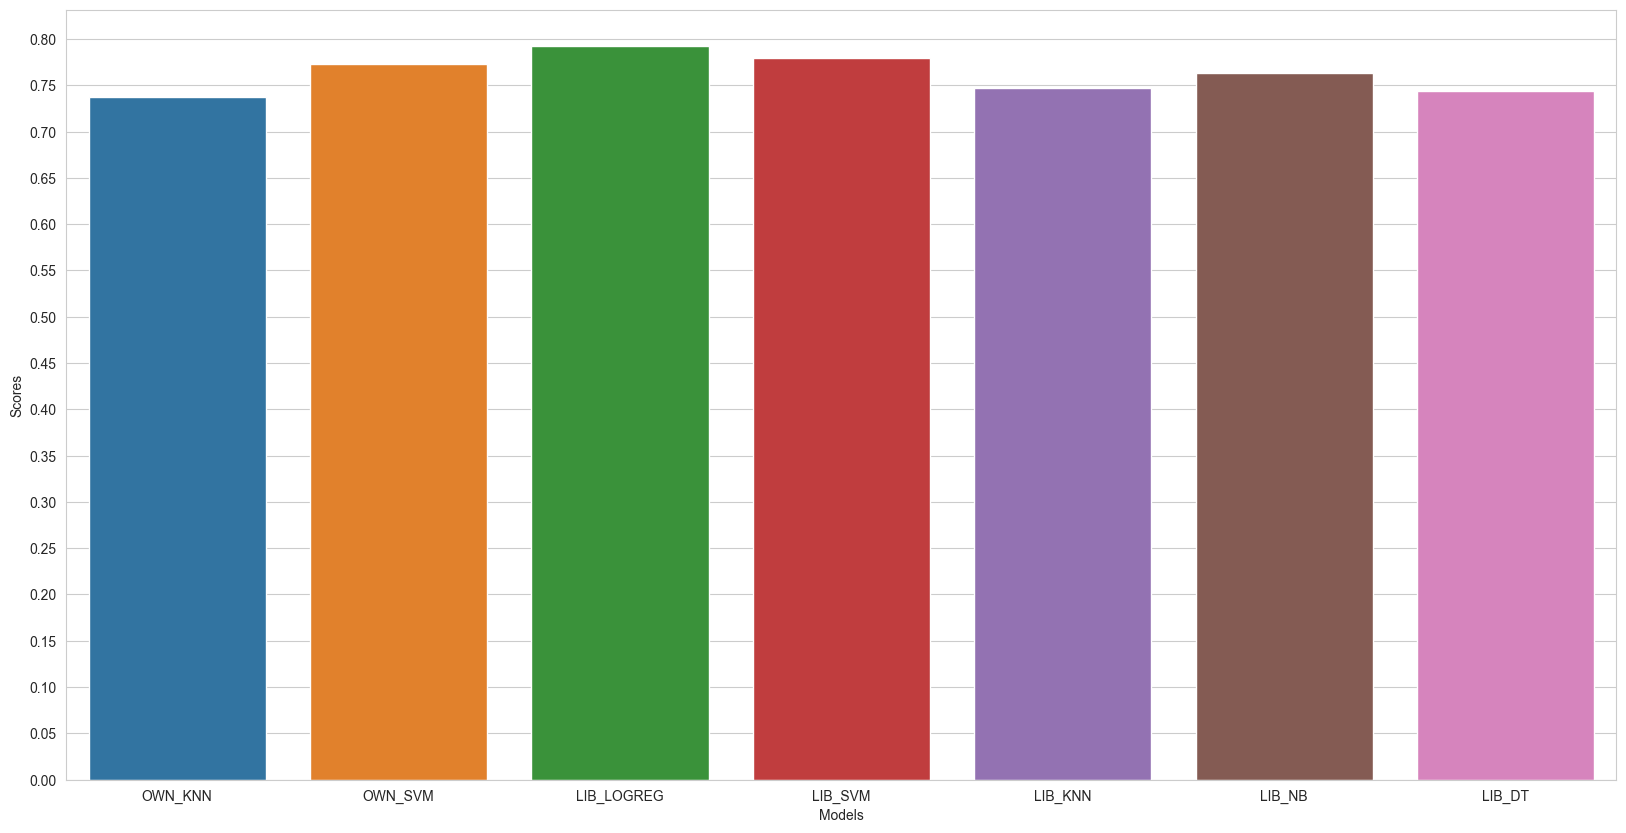

In [184]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
plt.xlabel("Models")
plt.ylabel("Scores")
plt.yticks(np.arange(0, 1.05, 0.05))

sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.show()

### Построение Confusion Matrix для моделей

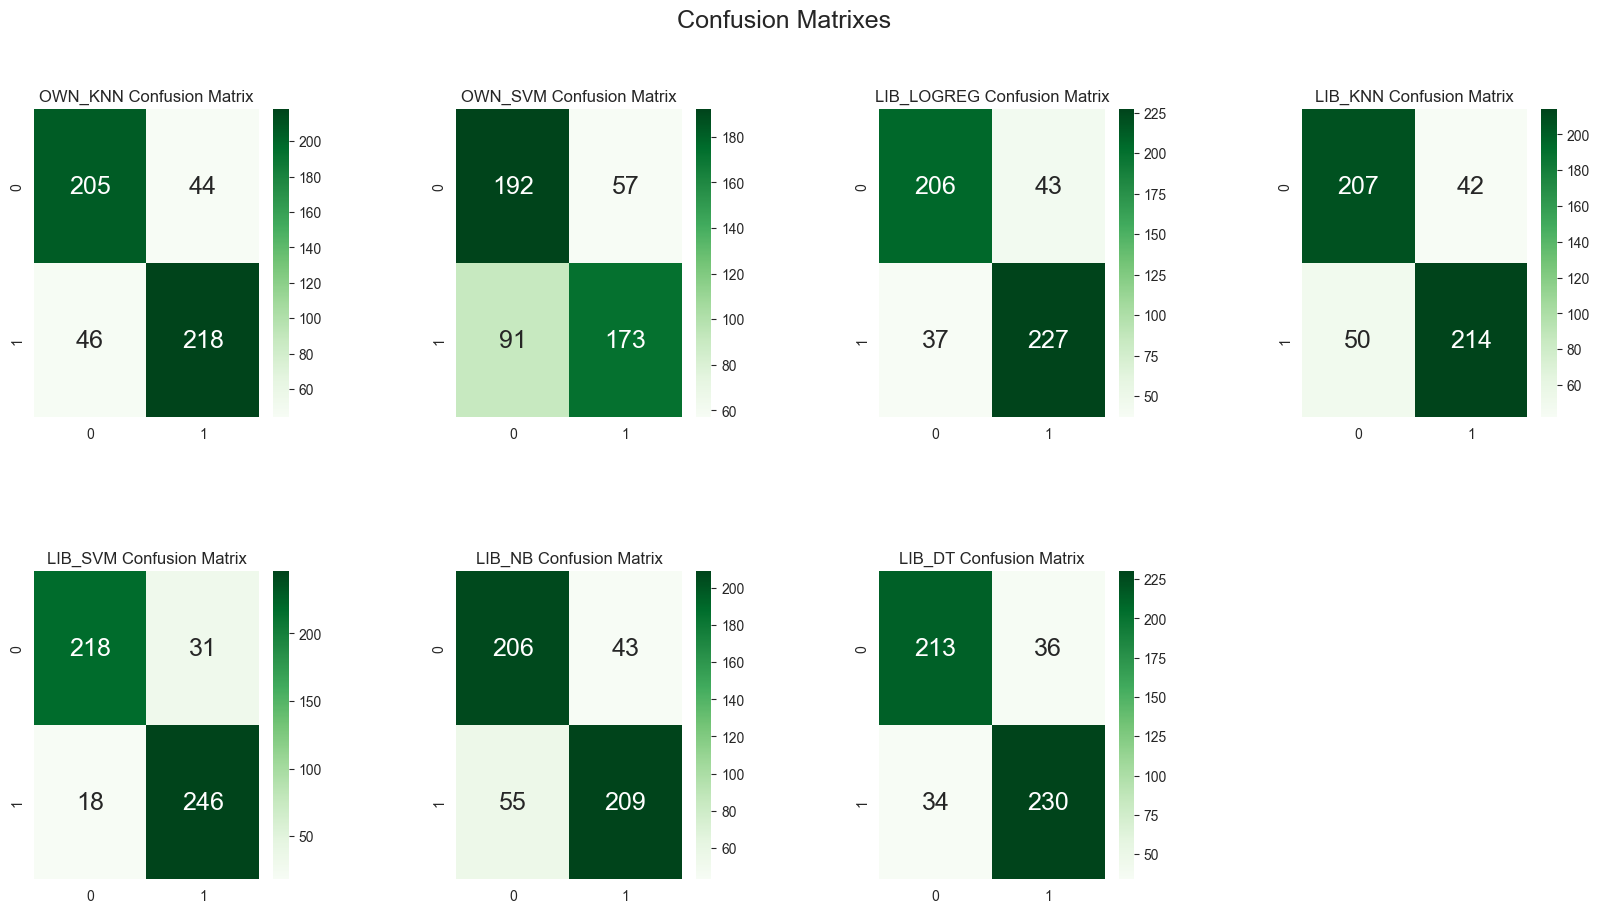

In [154]:
from sklearn.metrics import confusion_matrix

own_knn_cm = confusion_matrix(y_test, own_knn_y_test_pred)
own_svm_cm = confusion_matrix(y_test, own_svm_y_test_pred)
lib_logreg_cm = confusion_matrix(y_test, lib_logreg_y_test_pred)
lib_knn_cm = confusion_matrix(y_test, lib_knn_y_test_pred)
lib_svm_cm = confusion_matrix(y_test, lib_svm_y_test_pred)
lib_nb_cm = confusion_matrix(y_test, lib_nb_y_test_pred)
lib_dt_cm = confusion_matrix(y_test, lib_dt_y_test_pred)


plt.figure(figsize=(20, 10))
plt.suptitle("Confusion Matrixes", fontsize=18)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.subplot(2, 4, 1)
plt.title("OWN_KNN Confusion Matrix")
sns.heatmap(own_knn_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 2)
plt.title("OWN_SVM Confusion Matrix")
sns.heatmap(own_svm_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 3)
plt.title("LIB_LOGREG Confusion Matrix")
sns.heatmap(lib_logreg_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 4)
plt.title("LIB_KNN Confusion Matrix")
sns.heatmap(lib_knn_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 5)
plt.title("LIB_SVM Confusion Matrix")
sns.heatmap(lib_svm_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 6)
plt.title("LIB_NB Confusion Matrix")
sns.heatmap(lib_nb_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 7)
plt.title("LIB_DT Confusion Matrix")
sns.heatmap(lib_dt_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})
plt.show()

Все модели показали схожие результаты






# Второй датасет







In [156]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [160]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [161]:
df.shape

(768, 9)

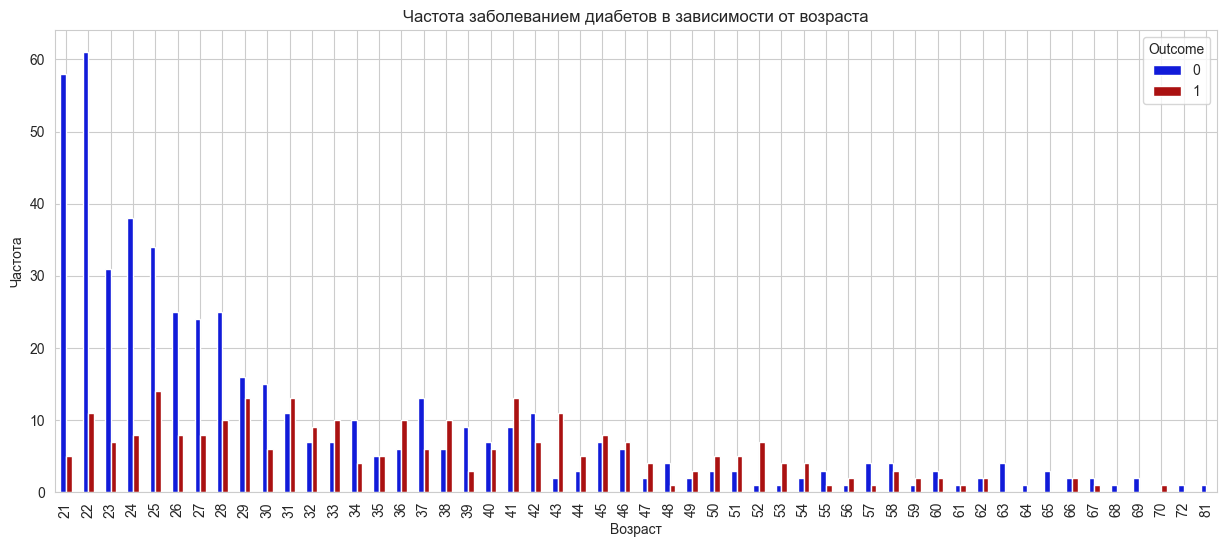

In [163]:
pd.crosstab(df.Age,df.Outcome).plot(kind="bar", figsize=(15, 6), color=['#111bd9','#AA1111'])
plt.title('Частота заболеванием диабетов в зависимости от возраста')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

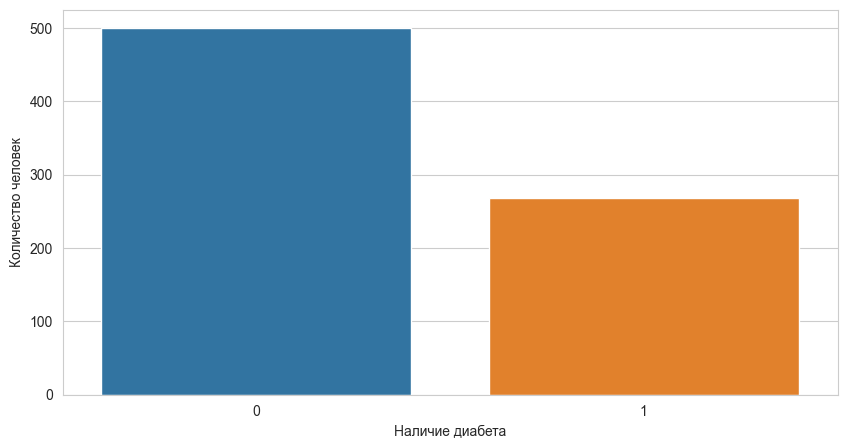

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Outcome")
plt.ylabel('Количество человек');
plt.xlabel('Наличие диабета');

### Разбиение выборки


In [167]:
y = df["Outcome"]
x = df.drop(columns=["Outcome"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=30)

### Масштабирование данных

In [168]:
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

### Подбор оптимальных признаков и кросс-валидация

In [169]:
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=StratifiedKFold(5), scoring='accuracy')
labelencoder = LabelEncoder()
y_transform = labelencoder.fit_transform(y_train)
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=x.columns)
rfecv.fit(x_train_scaled_df, y_transform)

selected_features = list(x_train.columns[rfecv.support_])
print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % selected_features)

Optimal number of features: 3
Selected features: ['Pregnancies', 'Glucose', 'BMI']


### KNN

In [172]:
cv = StratifiedKFold(5, shuffle=True, random_state=18)
param_grid = [{"num_neighbors": [3, 4, 6, 8, 11, 12, 16]}]
searcher = GridSearchCV(KNNClass(), param_grid=param_grid, cv=cv, verbose=5)
searcher = searcher.fit(x_train_scaled, y_train)
optimal_num_neighbors = searcher.best_params_["num_neighbors"]
print("KNN score =", optimal_num_neighbors)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ...................num_neighbors=3;, score=0.772 total time=   0.1s
[CV 2/5] END ...................num_neighbors=3;, score=0.728 total time=   0.1s
[CV 3/5] END ...................num_neighbors=3;, score=0.707 total time=   0.1s
[CV 4/5] END ...................num_neighbors=3;, score=0.674 total time=   0.1s
[CV 5/5] END ...................num_neighbors=3;, score=0.717 total time=   0.1s
[CV 1/5] END ...................num_neighbors=4;, score=0.772 total time=   0.1s
[CV 2/5] END ...................num_neighbors=4;, score=0.728 total time=   0.1s
[CV 3/5] END ...................num_neighbors=4;, score=0.707 total time=   0.1s
[CV 4/5] END ...................num_neighbors=4;, score=0.674 total time=   0.1s
[CV 5/5] END ...................num_neighbors=4;, score=0.717 total time=   0.1s
[CV 1/5] END ...................num_neighbors=6;, score=0.772 total time=   0.1s
[CV 2/5] END ...................num_neighbors=6;,

### SVM

In [174]:
learning_rate_grid = [0.1, 0.001]
iter_num_grid = [100, 1000]
lmda_grid = [0.1, 0.001]
cv = StratifiedKFold(5)
searcher = GridSearchCV(SVMClass(),
                        [{"learning_rate": learning_rate_grid, "iter_num": iter_num_grid, "lambda_": lmda_grid}],
                        cv=cv, verbose=5)
searcher.fit(x_train_scaled, y_train)
optimal_learning_rate = searcher.best_params_["learning_rate"]
optimal_iter_num = searcher.best_params_["iter_num"]
optimal_lambda = searcher.best_params_["lambda_"]
print(f"Optimal options {searcher.best_params_}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END iter_num=100, lambda_=0.1, learning_rate=0.1;, score=0.793 total time=   0.0s
[CV 2/5] END iter_num=100, lambda_=0.1, learning_rate=0.1;, score=0.739 total time=   0.0s
[CV 3/5] END iter_num=100, lambda_=0.1, learning_rate=0.1;, score=0.761 total time=   0.0s
[CV 4/5] END iter_num=100, lambda_=0.1, learning_rate=0.1;, score=0.772 total time=   0.0s
[CV 5/5] END iter_num=100, lambda_=0.1, learning_rate=0.1;, score=0.717 total time=   0.0s
[CV 1/5] END iter_num=100, lambda_=0.1, learning_rate=0.001;, score=0.793 total time=   0.0s
[CV 2/5] END iter_num=100, lambda_=0.1, learning_rate=0.001;, score=0.739 total time=   0.0s
[CV 3/5] END iter_num=100, lambda_=0.1, learning_rate=0.001;, score=0.761 total time=   0.0s
[CV 4/5] END iter_num=100, lambda_=0.1, learning_rate=0.001;, score=0.772 total time=   0.0s
[CV 5/5] END iter_num=100, lambda_=0.1, learning_rate=0.001;, score=0.717 total time=   0.0s
[CV 1/5] END iter_nu

### Библиотечная Логистическая регрессия

In [175]:
param_grid = {'C': [1E-3, 1E-1, 1, 1E+1, 1E+3]}
searcher = GridSearchCV(LogisticRegression(random_state=19), param_grid=param_grid, cv=cv, verbose=5)
searcher = searcher.fit(x_train_scaled, y_train)
optimal_logreg_c = searcher.best_params_["C"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...........................C=0.001;, score=0.630 total time=   0.0s
[CV 2/5] END ...........................C=0.001;, score=0.641 total time=   0.0s
[CV 3/5] END ...........................C=0.001;, score=0.641 total time=   0.0s
[CV 4/5] END ...........................C=0.001;, score=0.641 total time=   0.0s
[CV 5/5] END ...........................C=0.001;, score=0.641 total time=   0.0s
[CV 1/5] END .............................C=0.1;, score=0.750 total time=   0.0s
[CV 2/5] END .............................C=0.1;, score=0.793 total time=   0.0s
[CV 3/5] END .............................C=0.1;, score=0.728 total time=   0.0s
[CV 4/5] END .............................C=0.1;, score=0.761 total time=   0.0s
[CV 5/5] END .............................C=0.1;, score=0.783 total time=   0.0s
[CV 1/5] END ...............................C=1;, score=0.739 total time=   0.0s
[CV 2/5] END ...............................C=1;,

### Библиотечная KNN

In [176]:
param_grid = [{"n_neighbors": [2, 3, 5, 8, 9, 12, 13, 15, 17, 18],
               "weights": ['distance', 'uniform']}]
searcher = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=cv, verbose=5)
searcher = searcher.fit(x_train_scaled, y_train)
optimal_n_neighbors = searcher.best_params_["n_neighbors"]
optimal_weights = searcher.best_params_["weights"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...n_neighbors=2, weights=distance;, score=0.685 total time=   0.0s
[CV 2/5] END ...n_neighbors=2, weights=distance;, score=0.739 total time=   0.0s
[CV 3/5] END ...n_neighbors=2, weights=distance;, score=0.609 total time=   0.0s
[CV 4/5] END ...n_neighbors=2, weights=distance;, score=0.663 total time=   0.0s
[CV 5/5] END ...n_neighbors=2, weights=distance;, score=0.772 total time=   0.0s
[CV 1/5] END ....n_neighbors=2, weights=uniform;, score=0.674 total time=   0.0s
[CV 2/5] END ....n_neighbors=2, weights=uniform;, score=0.641 total time=   0.0s
[CV 3/5] END ....n_neighbors=2, weights=uniform;, score=0.630 total time=   0.0s
[CV 4/5] END ....n_neighbors=2, weights=uniform;, score=0.652 total time=   0.0s
[CV 5/5] END ....n_neighbors=2, weights=uniform;, score=0.685 total time=   0.0s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.761 total time=   0.0s
[CV 2/5] END ...n_neighbors=3, weights=distance

### Библиотечная SVM

In [177]:
param_grid = {"kernel": ["linear", "rbf"],
              "C": [0.1, 0.25, 0.5, 0.75, 1, 2],
              "gamma": ["scale", "auto", 1E-3, 1E-1, 1, 1E+1, 1E+3]}
searcher = GridSearchCV(SVC(random_state=19), param_grid=param_grid, cv=cv, verbose=5)
searcher = searcher.fit(x_train_scaled, y_train)
optimal_kernel = searcher.best_params_["kernel"]
optimal_svm_c = searcher.best_params_["C"]
optimal_gamma = searcher.best_params_["gamma"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.783 total time=   0.0s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.717 total time=   0.0s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.772 total time=   0.0s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.761 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.663 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.717 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.652 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.707 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.663 total time=   0.0s
[CV 1/5] END ..C=0.1, gamma=auto, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/5] END ..C=0.1, gamma=auto, kernel=linear

[CV 4/5] END .....C=0.5, gamma=auto, kernel=rbf;, score=0.739 total time=   0.0s
[CV 5/5] END .....C=0.5, gamma=auto, kernel=rbf;, score=0.783 total time=   0.0s
[CV 1/5] END .C=0.5, gamma=0.001, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/5] END .C=0.5, gamma=0.001, kernel=linear;, score=0.772 total time=   0.0s
[CV 3/5] END .C=0.5, gamma=0.001, kernel=linear;, score=0.728 total time=   0.0s
[CV 4/5] END .C=0.5, gamma=0.001, kernel=linear;, score=0.772 total time=   0.0s
[CV 5/5] END .C=0.5, gamma=0.001, kernel=linear;, score=0.772 total time=   0.0s
[CV 1/5] END ....C=0.5, gamma=0.001, kernel=rbf;, score=0.630 total time=   0.0s
[CV 2/5] END ....C=0.5, gamma=0.001, kernel=rbf;, score=0.641 total time=   0.0s
[CV 3/5] END ....C=0.5, gamma=0.001, kernel=rbf;, score=0.641 total time=   0.0s
[CV 4/5] END ....C=0.5, gamma=0.001, kernel=rbf;, score=0.641 total time=   0.0s
[CV 5/5] END ....C=0.5, gamma=0.001, kernel=rbf;, score=0.641 total time=   0.0s
[CV 1/5] END ...C=0.5, gamma

[CV 2/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 3/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 4/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.739 total time=   0.0s
[CV 5/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.783 total time=   0.0s
[CV 1/5] END .......C=1, gamma=1, kernel=linear;, score=0.739 total time=   0.0s
[CV 2/5] END .......C=1, gamma=1, kernel=linear;, score=0.772 total time=   0.0s
[CV 3/5] END .......C=1, gamma=1, kernel=linear;, score=0.728 total time=   0.0s
[CV 4/5] END .......C=1, gamma=1, kernel=linear;, score=0.772 total time=   0.0s
[CV 5/5] END .......C=1, gamma=1, kernel=linear;, score=0.772 total time=   0.0s
[CV 1/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.663 total time=   0.0s
[CV 2/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.652 total time=   0.0s
[CV 3/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.663 total time=   0.0s
[CV 4/5] END ..........C=1, 

### Библиотечная Naive Bayes

In [178]:
param_grid = [{"priors": [[0.5, 0.5], [0.33, 0.67], [0.67, 0.33], [0.25, 0.75], [0.75, 0.25]],
               "var_smoothing": np.logspace(0, -10, num=100)}]

searcher = GridSearchCV(GaussianNB(), param_grid=param_grid, cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_priors = searcher.best_params_["priors"]
optimal_var_smoothing = searcher.best_params_["var_smoothing"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV 1/5] END priors=[0.5, 0.5], var_smoothing=1.0;, score=0.750 total time=   0.0s
[CV 2/5] END priors=[0.5, 0.5], var_smoothing=1.0;, score=0.804 total time=   0.0s
[CV 3/5] END priors=[0.5, 0.5], var_smoothing=1.0;, score=0.717 total time=   0.0s
[CV 4/5] END priors=[0.5, 0.5], var_smoothing=1.0;, score=0.739 total time=   0.0s
[CV 5/5] END priors=[0.5, 0.5], var_smoothing=1.0;, score=0.772 total time=   0.0s
[CV 1/5] END priors=[0.5, 0.5], var_smoothing=0.7924828983539173;, score=0.750 total time=   0.0s
[CV 2/5] END priors=[0.5, 0.5], var_smoothing=0.7924828983539173;, score=0.793 total time=   0.0s
[CV 3/5] END priors=[0.5, 0.5], var_smoothing=0.7924828983539173;, score=0.728 total time=   0.0s
[CV 4/5] END priors=[0.5, 0.5], var_smoothing=0.7924828983539173;, score=0.739 total time=   0.0s
[CV 5/5] END priors=[0.5, 0.5], var_smoothing=0.7924828983539173;, score=0.761 total time=   0.0s
[CV 1/5] END priors=[0.5, 0.5],

[CV 1/5] END priors=[0.5, 0.5], var_smoothing=3.2745491628777316e-09;, score=0.772 total time=   0.0s
[CV 2/5] END priors=[0.5, 0.5], var_smoothing=3.2745491628777316e-09;, score=0.750 total time=   0.0s
[CV 3/5] END priors=[0.5, 0.5], var_smoothing=3.2745491628777316e-09;, score=0.750 total time=   0.0s
[CV 4/5] END priors=[0.5, 0.5], var_smoothing=3.2745491628777316e-09;, score=0.728 total time=   0.0s
[CV 5/5] END priors=[0.5, 0.5], var_smoothing=3.2745491628777316e-09;, score=0.739 total time=   0.0s
[CV 1/5] END priors=[0.5, 0.5], var_smoothing=2.595024211399732e-09;, score=0.772 total time=   0.0s
[CV 2/5] END priors=[0.5, 0.5], var_smoothing=2.595024211399732e-09;, score=0.750 total time=   0.0s
[CV 3/5] END priors=[0.5, 0.5], var_smoothing=2.595024211399732e-09;, score=0.750 total time=   0.0s
[CV 4/5] END priors=[0.5, 0.5], var_smoothing=2.595024211399732e-09;, score=0.728 total time=   0.0s
[CV 5/5] END priors=[0.5, 0.5], var_smoothing=2.595024211399732e-09;, score=0.739 tota

[CV 4/5] END priors=[0.33, 0.67], var_smoothing=1.2915496650148826e-09;, score=0.685 total time=   0.0s
[CV 5/5] END priors=[0.33, 0.67], var_smoothing=1.2915496650148826e-09;, score=0.717 total time=   0.0s
[CV 1/5] END priors=[0.33, 0.67], var_smoothing=1.0235310218990269e-09;, score=0.783 total time=   0.0s
[CV 2/5] END priors=[0.33, 0.67], var_smoothing=1.0235310218990269e-09;, score=0.685 total time=   0.0s
[CV 3/5] END priors=[0.33, 0.67], var_smoothing=1.0235310218990269e-09;, score=0.728 total time=   0.0s
[CV 4/5] END priors=[0.33, 0.67], var_smoothing=1.0235310218990269e-09;, score=0.685 total time=   0.0s
[CV 5/5] END priors=[0.33, 0.67], var_smoothing=1.0235310218990269e-09;, score=0.717 total time=   0.0s
[CV 1/5] END priors=[0.33, 0.67], var_smoothing=8.111308307896889e-10;, score=0.783 total time=   0.0s
[CV 2/5] END priors=[0.33, 0.67], var_smoothing=8.111308307896889e-10;, score=0.685 total time=   0.0s
[CV 3/5] END priors=[0.33, 0.67], var_smoothing=8.111308307896889e

[CV 2/5] END priors=[0.67, 0.33], var_smoothing=3.1992671377973845e-10;, score=0.772 total time=   0.0s
[CV 3/5] END priors=[0.67, 0.33], var_smoothing=3.1992671377973845e-10;, score=0.707 total time=   0.0s
[CV 4/5] END priors=[0.67, 0.33], var_smoothing=3.1992671377973845e-10;, score=0.750 total time=   0.0s
[CV 5/5] END priors=[0.67, 0.33], var_smoothing=3.1992671377973845e-10;, score=0.772 total time=   0.0s
[CV 1/5] END priors=[0.67, 0.33], var_smoothing=2.5353644939701164e-10;, score=0.739 total time=   0.0s
[CV 2/5] END priors=[0.67, 0.33], var_smoothing=2.5353644939701164e-10;, score=0.772 total time=   0.0s
[CV 3/5] END priors=[0.67, 0.33], var_smoothing=2.5353644939701164e-10;, score=0.707 total time=   0.0s
[CV 4/5] END priors=[0.67, 0.33], var_smoothing=2.5353644939701164e-10;, score=0.750 total time=   0.0s
[CV 5/5] END priors=[0.67, 0.33], var_smoothing=2.5353644939701164e-10;, score=0.772 total time=   0.0s
[CV 1/5] END priors=[0.67, 0.33], var_smoothing=2.00923300256504

[CV 5/5] END priors=[0.25, 0.75], var_smoothing=1e-10;, score=0.674 total time=   0.0s
[CV 1/5] END priors=[0.75, 0.25], var_smoothing=1.0;, score=0.696 total time=   0.0s
[CV 2/5] END priors=[0.75, 0.25], var_smoothing=1.0;, score=0.728 total time=   0.0s
[CV 3/5] END priors=[0.75, 0.25], var_smoothing=1.0;, score=0.685 total time=   0.0s
[CV 4/5] END priors=[0.75, 0.25], var_smoothing=1.0;, score=0.663 total time=   0.0s
[CV 5/5] END priors=[0.75, 0.25], var_smoothing=1.0;, score=0.685 total time=   0.0s
[CV 1/5] END priors=[0.75, 0.25], var_smoothing=0.7924828983539173;, score=0.728 total time=   0.0s
[CV 2/5] END priors=[0.75, 0.25], var_smoothing=0.7924828983539173;, score=0.739 total time=   0.0s
[CV 3/5] END priors=[0.75, 0.25], var_smoothing=0.7924828983539173;, score=0.696 total time=   0.0s
[CV 4/5] END priors=[0.75, 0.25], var_smoothing=0.7924828983539173;, score=0.674 total time=   0.0s
[CV 5/5] END priors=[0.75, 0.25], var_smoothing=0.7924828983539173;, score=0.728 total t

### Библиотечная Decision Tree

In [179]:
param_grid = [{"criterion": ["gini", "entropy", "log_loss"],
               "splitter": ["best", "random"],
               "max_depth": [10, 20, 30],
               "min_samples_split": [2, 5, 10],
               "min_samples_leaf": [2, 5, 10],
               "max_features": [2, 5, 10]}]
searcher = GridSearchCV(DecisionTreeClassifier(random_state=19), param_grid=param_grid, cv=cv, verbose=5)
searcher = searcher.fit(x_train_scaled, y_train)
optimal_criterion = searcher.best_params_["criterion"]
optimal_splitter = searcher.best_params_["splitter"]
optimal_max_depth = searcher.best_params_["max_depth"]
optimal_min_samples_split = searcher.best_params_["min_samples_split"]
optimal_min_samples_leaf = searcher.best_params_["min_samples_leaf"]
optimal_max_features = searcher.best_params_["max_features"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[CV 1/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.641 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.663 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.663 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.739 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.674 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.663 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_featu

[CV 2/5] END criterion=gini, max_depth=10, max_features=10, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.761 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=10, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.717 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=10, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.652 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=10, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.761 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=10, min_samples_leaf=10, min_samples_split=5, splitter=best;, score=0.728 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=10, min_samples_leaf=10, min_samples_split=5, splitter=best;, score=0.674 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=10, min_samples_leaf=10, min_samples_split

[CV 1/5] END criterion=gini, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.717 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.674 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.739 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.685 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.685 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=random;, score=0.652 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=30, max_features=2, min_samples_leaf=2, min_samples_split=2, splitter=random;

[CV 4/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.663 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=2, splitter=best;, score=0.674 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.739 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.641 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.728 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=2, splitter=random;, score=0.696 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=2, min_samples_leaf=5, min_sample

[CV 3/5] END criterion=entropy, max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=10, splitter=best;, score=0.685 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=10, splitter=best;, score=0.663 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=10, splitter=best;, score=0.674 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=10, splitter=random;, score=0.696 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=10, splitter=random;, score=0.685 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=10, splitter=random;, score=0.728 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=2, min_samples_leaf=5, min_sa

[CV 4/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.663 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=10, min_samples_split=2, splitter=random;, score=0.609 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=10, min_samples_split=5, splitter=best;, score=0.652 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=10, min_samples_split=5, splitter=best;, score=0.663 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=10, min_samples_split=5, splitter=best;, score=0.685 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=10, min_samples_split=5, splitter=best;, score=0.707 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=30, max_features=2, min_samples_leaf=10, min_sam

[CV 2/5] END criterion=log_loss, max_depth=10, max_features=2, min_samples_leaf=10, min_samples_split=10, splitter=random;, score=0.652 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=2, min_samples_leaf=10, min_samples_split=10, splitter=random;, score=0.707 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=2, min_samples_leaf=10, min_samples_split=10, splitter=random;, score=0.663 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=10, max_features=2, min_samples_leaf=10, min_samples_split=10, splitter=random;, score=0.609 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=5, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.685 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=5, min_samples_leaf=2, min_samples_split=2, splitter=best;, score=0.620 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=5, min_samples_lea

[CV 1/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=5, splitter=best;, score=0.641 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=5, splitter=best;, score=0.663 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=5, splitter=best;, score=0.674 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=5, splitter=best;, score=0.663 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=5, splitter=best;, score=0.685 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=2, min_samples_split=5, splitter=random;, score=0.717 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=20, max_features=5, min_samples_leaf=2, min_sampl

[CV 2/5] END criterion=log_loss, max_depth=30, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=best;, score=0.728 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=30, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=best;, score=0.674 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=30, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=best;, score=0.674 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=30, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=best;, score=0.772 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=30, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=0.630 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=30, max_features=5, min_samples_leaf=2, min_samples_split=10, splitter=random;, score=0.750 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=30, max_features=5, min_samples_leaf=2, m

### Самостоятельная реализация

In [180]:
own_knn = KNNClass(num_neighbors=optimal_num_neighbors)
own_knn = own_knn.fit(x_train_scaled, y_train)
own_knn_y_test_pred = own_knn.predict(x_test_scaled)
own_knn_score = accuracy_score(y_test, own_knn_y_test_pred)
scores['OWN_KNN'] = own_knn_score
print("OWN_KNN score =", own_knn_score)

own_svm = SVMClass(alpha_value=1E-1, lamda_value=1E-1)
own_svm = own_svm.fit(x_train_scaled, y_train)
own_svm_y_test_pred = own_svm.predict(x_test_scaled)
own_svm_score = accuracy_score(y_test, own_svm_y_test_pred)
scores['OWN_SVM'] = own_svm_score
print("OWN_SVM score =", own_svm_score)

lib_logreg = LogisticRegression(C=optimal_logreg_c, random_state=19)
lib_logreg = lib_logreg.fit(x_train_scaled, y_train)
lib_logreg_y_test_pred = lib_logreg.predict(x_test_scaled)
lib_logreg_score = accuracy_score(y_test, lib_logreg_y_test_pred)
scores['LIB_LOGREG'] = lib_logreg_score
print("LIB_LOGREG score =", lib_logreg_score)

OWN_KNN score = 0.737012987012987
OWN_SVM score = 0.7727272727272727
LIB_LOGREG score = 0.7922077922077922


### Библиотечная реализация

In [181]:
lib_svm = SVC(kernel=optimal_kernel, C=optimal_svm_c, gamma=optimal_gamma, random_state=19)
lib_svm = lib_svm.fit(x_train_scaled, y_train)
lib_svm_y_test_pred = lib_svm.predict(x_test_scaled)
lib_svm_score = accuracy_score(y_test, lib_svm_y_test_pred)
scores['LIB_SVM'] = lib_svm_score
print("LIB_SVM score =", lib_svm_score)


lib_knn = KNeighborsClassifier(n_neighbors=optimal_n_neighbors)
lib_knn = lib_knn.fit(x_train_scaled, y_train)
lib_knn_y_test_pred = lib_knn.predict(x_test_scaled)
lib_knn_score = accuracy_score(y_test, lib_knn_y_test_pred)
scores['LIB_KNN'] = lib_knn_score
print("LIB_KNN score =", lib_knn_score)

lib_nb = GaussianNB(priors=optimal_priors, var_smoothing=optimal_var_smoothing)
lib_nb = lib_nb.fit(x_train_scaled, y_train)
lib_nb_y_test_pred = lib_nb.predict(x_test_scaled)
lib_nb_score = accuracy_score(y_test, lib_nb_y_test_pred)
scores['LIB_NB'] = lib_nb_score
print("LIB_NB score =", lib_nb_score)

lib_dt = DecisionTreeClassifier(criterion=optimal_criterion, max_depth=optimal_max_depth,
                                    max_features=optimal_max_features, min_samples_leaf=optimal_min_samples_leaf,
                                    min_samples_split=optimal_min_samples_split, splitter=optimal_splitter, random_state=19)
lib_dt = lib_dt.fit(x_train_scaled, y_train)
lib_dt_y_test_pred = lib_dt.predict(x_test_scaled)
lib_dt_score = accuracy_score(y_test, lib_dt_y_test_pred)
scores['LIB_DT'] = lib_dt_score
print("LIB_DT score =", lib_dt_score)

LIB_SVM score = 0.7792207792207793
LIB_KNN score = 0.7467532467532467
LIB_NB score = 0.762987012987013
LIB_DT score = 0.7435064935064936


### СРАВНЕНИЕ

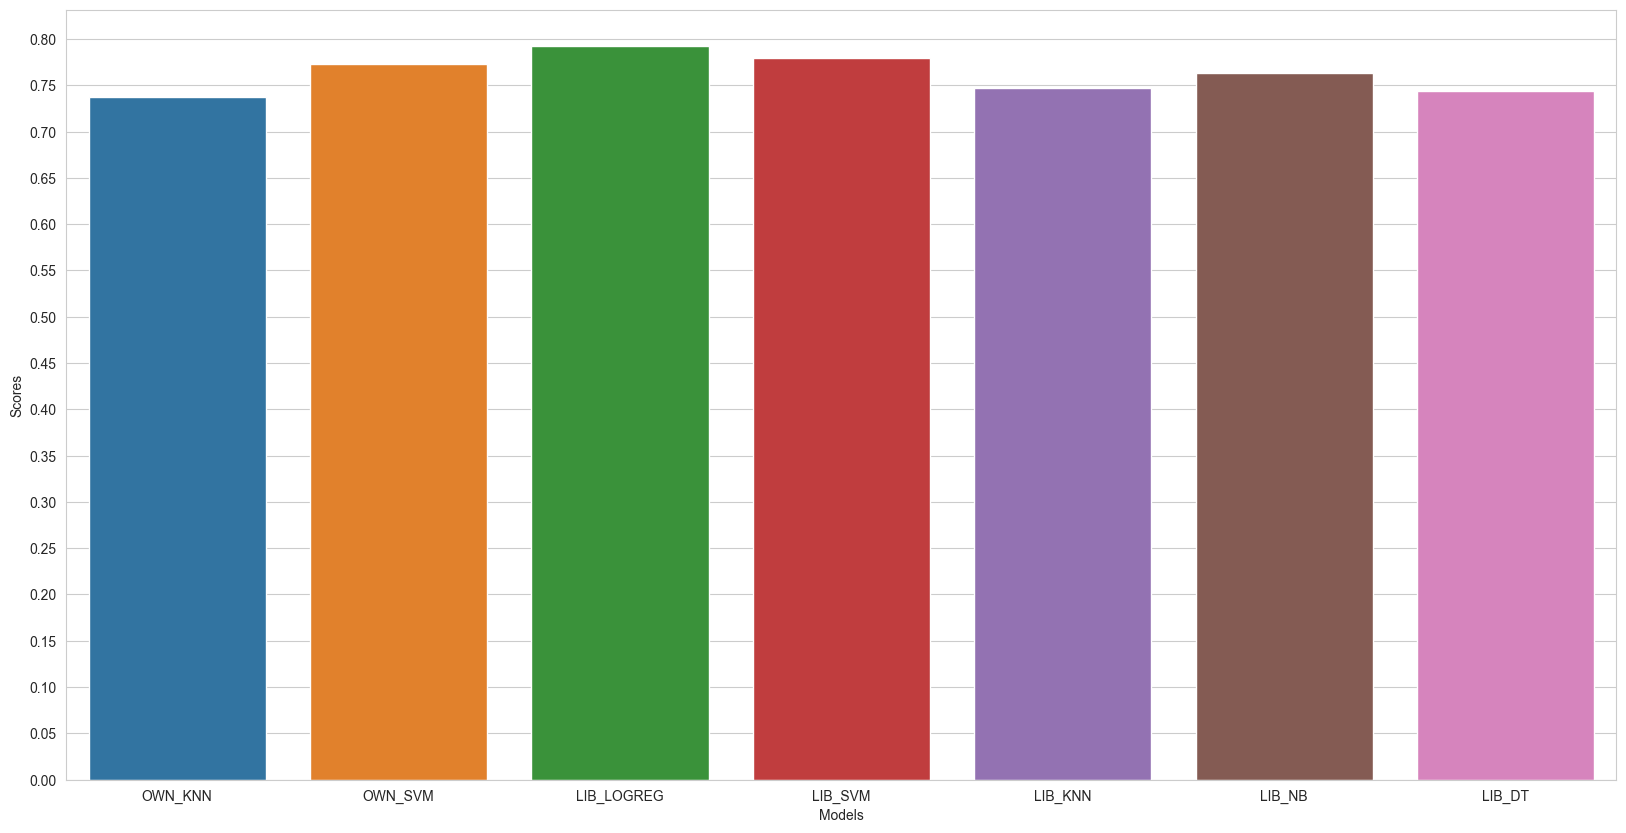

In [183]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
plt.xlabel("Models")
plt.ylabel("Scores")
plt.yticks(np.arange(0, 1.05, 0.05))

sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.show()

### Построение Confusion Matrix для моделей

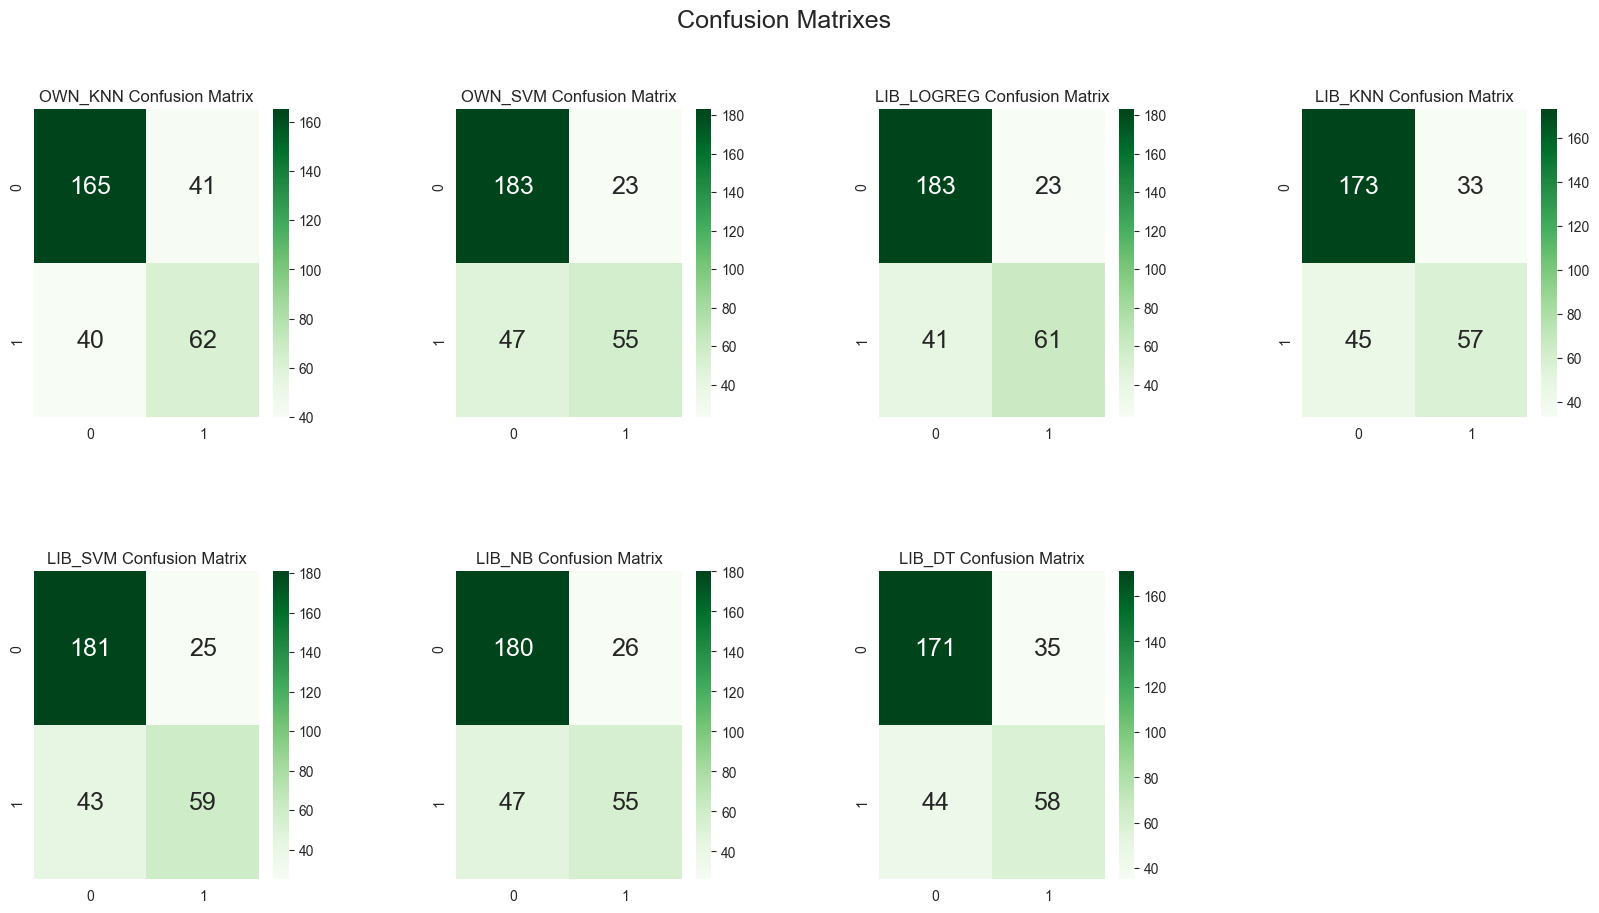

In [182]:
from sklearn.metrics import confusion_matrix

own_knn_cm = confusion_matrix(y_test, own_knn_y_test_pred)
own_svm_cm = confusion_matrix(y_test, own_svm_y_test_pred)
lib_logreg_cm = confusion_matrix(y_test, lib_logreg_y_test_pred)
lib_knn_cm = confusion_matrix(y_test, lib_knn_y_test_pred)
lib_svm_cm = confusion_matrix(y_test, lib_svm_y_test_pred)
lib_nb_cm = confusion_matrix(y_test, lib_nb_y_test_pred)
lib_dt_cm = confusion_matrix(y_test, lib_dt_y_test_pred)


plt.figure(figsize=(20, 10))
plt.suptitle("Confusion Matrixes", fontsize=18)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.subplot(2, 4, 1)
plt.title("OWN_KNN Confusion Matrix")
sns.heatmap(own_knn_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 2)
plt.title("OWN_SVM Confusion Matrix")
sns.heatmap(own_svm_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 3)
plt.title("LIB_LOGREG Confusion Matrix")
sns.heatmap(lib_logreg_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 4)
plt.title("LIB_KNN Confusion Matrix")
sns.heatmap(lib_knn_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 5)
plt.title("LIB_SVM Confusion Matrix")
sns.heatmap(lib_svm_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 6)
plt.title("LIB_NB Confusion Matrix")
sns.heatmap(lib_nb_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})

plt.subplot(2, 4, 7)
plt.title("LIB_DT Confusion Matrix")
sns.heatmap(lib_dt_cm, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 18})
plt.show()

Все модели показали схожие результаты